# Portland Trail Blazers - Customer Lifetime Value (Regression)
* StelllarAlgo Data Science
* Ryan Kazmerik
* Jul 14, 2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pycaret.regression import *

## Hypothesis:

**Customer Lifetime Value (CLTV)** represents the total amount of money a customer is expected to spend in a business during his/her lifetime. This is an important metric to monitor because it helps to make decisions about how much money to invest in acquiring new customers and retaining existing ones.

We propose to build a CLTV regression model trained on RFM data from past season that is capable of predicting future CLTV for the next season.

In [18]:
df = pd.read_parquet("./data/ptb_ticket_purchases_all.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3949410 entries, 0 to 3949409
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   dimcustomermasterid  int64  
 1   purchasedate         object 
 2   ticketcount          int64  
 3   revenue              float64
 4   isplanproduct        bool   
 5   producttype          object 
 6   subproductname       object 
 7   seasonyear           int64  
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 214.7+ MB


In [19]:
df.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,isplanproduct,producttype,subproductname,seasonyear
0,3,2017-11-21,3,75.0,False,Other,Group,2017
1,16,2018-02-02,2,85.0,True,Package,Half Season,2017
2,16,2018-02-02,2,85.0,True,Package,Half Season,2017
3,48,2019-02-05,1,10.0,False,Individual,Individual,2018
4,87,2021-05-28,2,144.0,False,Individual,Individual,2020


For our analysis we will only consider **non-package buyers**, let's see how much data we have for NP buyers and what sub-products are included:

In [20]:
df['isplanproduct'].value_counts()

False    2931853
True     1017557
Name: isplanproduct, dtype: int64

Remove the rows where isplanproduct = True:

In [21]:
df = df[df['isplanproduct'] == False]

df.drop(columns=["isplanproduct"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2931853 entries, 0 to 3949409
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   dimcustomermasterid  int64  
 1   purchasedate         object 
 2   ticketcount          int64  
 3   revenue              float64
 4   producttype          object 
 5   subproductname       object 
 6   seasonyear           int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 178.9+ MB


Let's include data from 2018 to present in our analysis:

In [22]:
df = df[df["seasonyear"] >= 2018]
df.shape

(2471314, 7)

We'll also have a look at the included product and subproduct types:

In [23]:
df["producttype"].value_counts()

Individual    2246352
Comp           142473
Other           82489
Name: producttype, dtype: int64

In [24]:
df["subproductname"].value_counts()

Individual           2245724
Comp                  141707
Suite                  39145
Group                  38697
Deposit                 1842
Group Broker            1459
Suite Broker            1345
Comp Broker              766
Individual Broker        628
Deposit Broker             1
Name: subproductname, dtype: int64

Let's remove the broker records so we are looking at actual customers:

In [25]:
df = df[df["subproductname"].isin(["Individual", "Comp", "Suite", "Group", "Deposit"])]
df.reset_index(drop=True, inplace=True)

df["subproductname"].value_counts()

Individual    2245724
Comp           141707
Suite           39145
Group           38697
Deposit          1842
Name: subproductname, dtype: int64

In [26]:
df.head(10)

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear
0,48,2019-02-05,1,10.0,Individual,Individual,2018
1,87,2021-05-28,2,144.0,Individual,Individual,2020
2,95,2021-05-24,4,160.0,Individual,Individual,2020
3,35,2020-02-08,5,90.0,Individual,Individual,2019
4,70,2019-03-27,1,116.5,Individual,Individual,2018
5,20,2019-02-27,8,112.0,Individual,Individual,2018
6,48,2019-02-05,1,10.0,Individual,Individual,2018
7,95,2021-05-06,2,134.0,Individual,Individual,2020
8,95,2021-05-24,5,200.0,Individual,Individual,2020
9,41,2021-09-15,2,242.0,Individual,Individual,2021


### Exploratory Data Analysis (EDA)

Let's have a look at the data and decide whether we need any data cleaning and data transformation for further analysis.

By reading the profiling report, we can see that the following actions should be taken to improve the dataset quality:
* Remove missing values from revenue (23.3%)
* Remove zero values from revenue (6.8%)

In [27]:
df.dropna(subset=['revenue'], inplace=True)

Let's check NULL records in the revenue column

In [28]:
df['revenue'].isnull().sum()

0

Let's also drop any rows where revenue = 0, and then check the value counts to ensure the zero values are gone

In [29]:
df = df[df['revenue'] > 0]
df['revenue'].value_counts(bins=[0, 1000, 10000, 100000])

(-0.001, 1000.0]       1424893
(1000.0, 10000.0]        28898
(10000.0, 100000.0]        208
Name: revenue, dtype: int64

### Data Types

Let's look at the data types in our dataframe to see if we need to convert any values to a different type

In [30]:
df.dtypes

dimcustomermasterid      int64
purchasedate            object
ticketcount              int64
revenue                float64
producttype             object
subproductname          object
seasonyear               int64
dtype: object

Purchase date should be a datetime not an object (string), all of the other inferred data types look correct

In [31]:
df['purchasedate'] =  pd.to_datetime(df['purchasedate'], format='%Y-%m-%d')

### Distributions

Let's look at the distributions for our three key fields: purchasedate, ticketcount and revenue

Text(0, 0.5, 'Fans')

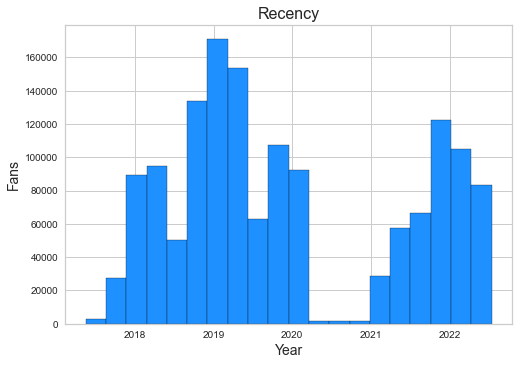

In [32]:
plt.hist(df["purchasedate"], bins=20, color='dodgerblue', edgecolor='black')
plt.title("Recency", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Fans", fontsize=14)

### Period of Time

In [33]:
print(f"Start Date: {df['purchasedate'].min()}")
print(f"End Date: {df['purchasedate'].max()}")

Start Date: 2017-05-17 00:00:00
End Date: 2022-07-14 00:00:00


There was abnormally low purchasing during the 2020 season because of stadium closures due to the COVID-19 pandemic. There are also some outlier purchases from before 2017

We may want to remove these from our training dataset, but let's leave them in for now

Text(0, 0.5, 'Fans')

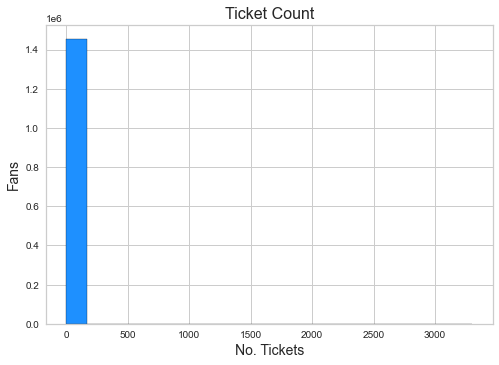

In [34]:
plt.hist(df["ticketcount"], bins=20, color='dodgerblue', edgecolor='black')
plt.title("Ticket Count", fontsize=16)
plt.xlabel("No. Tickets", fontsize=14)
plt.ylabel("Fans", fontsize=14)

In [35]:
df['ticketcount'].value_counts(bins=[0, 5, 10, 50, 100, 10000])

(-0.001, 5.0]       1397196
(5.0, 10.0]           43389
(10.0, 50.0]          12528
(50.0, 100.0]           579
(100.0, 10000.0]        307
Name: ticketcount, dtype: int64

We can see that ticket count is highly skewed toward 1 ticket, we may want to remove the outliers here but let's leave it for now

Text(0, 0.5, 'Fans')

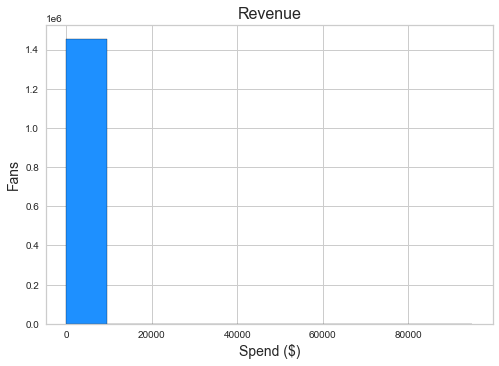

In [36]:
plt.hist(df["revenue"], color='dodgerblue', edgecolor='black')
plt.title("Revenue", fontsize=16)
plt.xlabel("Spend ($)", fontsize=14)
plt.ylabel("Fans", fontsize=14)

In [37]:
df.revenue.value_counts(bins=[0, 100, 1000, 10000, 100000, 1000000])

(100.0, 1000.0]          733893
(-0.001, 100.0]          691000
(1000.0, 10000.0]         28898
(10000.0, 100000.0]         208
(100000.0, 1000000.0]         0
Name: revenue, dtype: int64

In [38]:
df_big_spenders = df[df['revenue'] > 10000]
df_big_spenders.head()

,dimcustomermasterid,purchasedate,ticketcount,revenue,producttype,subproductname,seasonyear
2515,18935,2019-08-26,64,11885.70,Other,Suite,2019
2869,22798,2020-11-24,4,12154.64,Individual,Individual,2020
3096,19413,2018-10-25,16,14505.04,Other,Suite,2018
3387,18935,2018-10-25,68,11657.14,Other,Suite,2018
5894,45511,2018-10-25,43,11629.55,Other,Suite,2018


Most fans spend between 1 and 1000 dollars on a purchase, but some spend much more (df_big_spenders), we may want to remove these outliers but let's leave them in for now

### Model Training
We need to create training and evaluation datasets to train our regression model and evaluate the model performance against unseen data points


In [39]:
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (1235899, 7)
Unseen Data For Predictions: (218100, 7)



In [41]:
setup(
    data = df_train, 
    date_features=["purchasedate"],
    ignore_features=["dimcustomermasterid", "producttype", "subproductname", "seasonyear"],
    target='revenue', 
    silent=True,
    verbose=True,
    session_id=123
);

,Description,Value
0,session_id,123
1,Target,revenue
2,Original Data,"(1235899, 7)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(865129, 22)"


Let's look at the regression models we can experiment with

In [42]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


We could experiment with different model types, but for now let's choose linear regression.

In [43]:
model_matrix = compare_models(
    fold=10,
    include=["lr"]
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,147.7477,138191.0781,370.6675,0.1975,1.1744,2.3789,1.0620


In [44]:
best_model = create_model(model_matrix)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,147.3820,143909.3906,379.3539,0.0032,1.1678,2.2568
1,148.8402,150182.7500,387.5342,0.1982,1.1742,2.2941
2,149.0095,143800.6562,379.2106,0.1707,1.1760,2.5309
3,147.7643,181431.5000,425.9478,0.1354,1.1677,2.2639
4,145.3988,105375.3438,324.6157,0.1828,1.1740,2.4350
5,147.1721,125131.0547,353.7387,0.2552,1.1784,2.8133
6,148.3394,126797.0234,356.0857,0.2260,1.1745,2.2868
7,146.4461,110210.0625,331.9790,0.2012,1.1801,2.3161
8,149.1430,147897.6562,384.5746,0.4517,1.1753,2.2920
9,147.9812,147175.3438,383.6344,0.1508,1.1765,2.2997


We can see the model performance, the R2 metric is a measure of how well the model fits our dataset on a scale of 0 (not good at all) to 1 (very good, possibly overfit)

We can plot the results of the model line of best fit, vs. the predicted values line of best fit

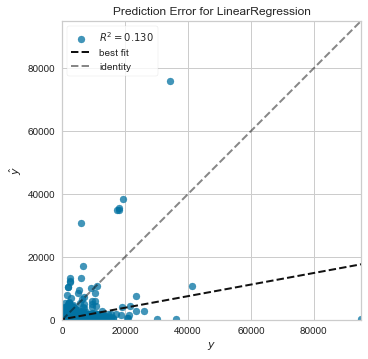

In [45]:
plot_model(best_model, plot = 'error')

We can also plot the feature importance to see what features are impacting model prediction the most

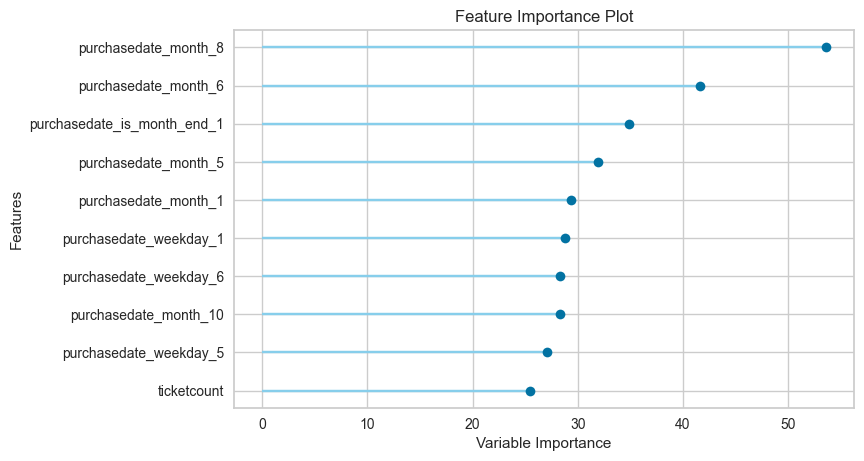

In [46]:
plot_model(best_model, plot='feature')

### Observations

* Observation 1
* Observation 2
* Observation 3

### Conclusion

Add a conclusion to the experiment here